In [1]:
from datetime import timedelta, datetime
import glob
from itertools import chain
import json
import os
import re

import numpy as np
import pandas as pd

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from konlpy.tag import Twitter
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
#font_path = 'fonts/MalgunGothic.ttf'
#font_name = fm.FontProperties(fname=font_path, size=10).get_name()
#plt.rc('font', family=font_name, size=12)
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()

mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')

In [2]:
pd.options.mode.chained_assignment = None

## 2. 곡 별 메타 데이터 : `song_meta.json`

### 데이터 불러오기

In [13]:
song_meta = pd.read_json('song_meta.json', typ = 'frame', encoding='utf-8')

In [14]:
song_meta

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,[GN0900],[Various Artists],0
1,"[GN1601, GN1606]",20080421,"Bach : Partitas Nos. 2, 3 & 4",376431,[29966],"Bach : Partita No. 4 In D Major, BWV 828 - II....",[GN1600],[Murray Perahia],1
2,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),[GN0900],[Peter Gabriel],2
3,"[GN1102, GN1101]",20151016,Feeling Right (Everything Is Nice) (Feat. Popc...,2644882,[838543],Feeling Right (Everything Is Nice) (Feat. Popc...,[GN1100],[Matoma],3
4,"[GN1802, GN1801]",20110824,그남자 그여자,2008470,[560160],그남자 그여자,[GN1800],[Jude Law],4
...,...,...,...,...,...,...,...,...,...
707984,[GN2001],19991219,The Best Best Of The Black President,65254,[166499],Coffin For Head Of State,[GN2000],[Fela Kuti],707984
707985,[GN0901],19860000,True Colors,44141,[11837],Change Of Heart,[GN0900],[Cyndi Lauper],707985
707986,"[GN0105, GN0101]",20160120,행보 2015 윤종신 / 작사가 윤종신 Live Part.1,2662866,[437],스치듯 안녕,[GN0100],[윤종신],707986
707987,"[GN1807, GN1801]",20131217,명상의 시간을 위한 뉴에이지 음악,2221722,[729868],숲의 빛,[GN1800],[Nature Piano],707987


In [15]:
song_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 9 columns):
song_gn_dtl_gnr_basket    707989 non-null object
issue_date                707989 non-null int64
album_name                707985 non-null object
album_id                  707989 non-null int64
artist_id_basket          707989 non-null object
song_name                 707989 non-null object
song_gn_gnr_basket        707989 non-null object
artist_name_basket        707989 non-null object
id                        707989 non-null int64
dtypes: int64(3), object(6)
memory usage: 48.6+ MB


- **총 707,989곡의 메타 정보가 담겨 있으며** 포함하는 값은 아래와 같습니다.
  + `song_gn_dtl_gnr_basket` : 상세 장르 코드
  + `issue_date` : 곡 발매 일자 (yyyymmdd)
  + `album_name` : 앨범 명
  + `album_id` : 앨범 아이디
  + `artist_id_basket` : 아티스트 아이디 (복수일 경우 띄어쓰기로 구분)
  + `song_name` : 곡 명
  + `song_gn_gnr_basket` : 대분류 장르코드
  + `artist_name_basket` : 아티스트 명 (복수일 경우 띄어쓰기로 구분)
  + `id` : 곡 아이디

<br>

### 발매 년도 별 곡 비중은?

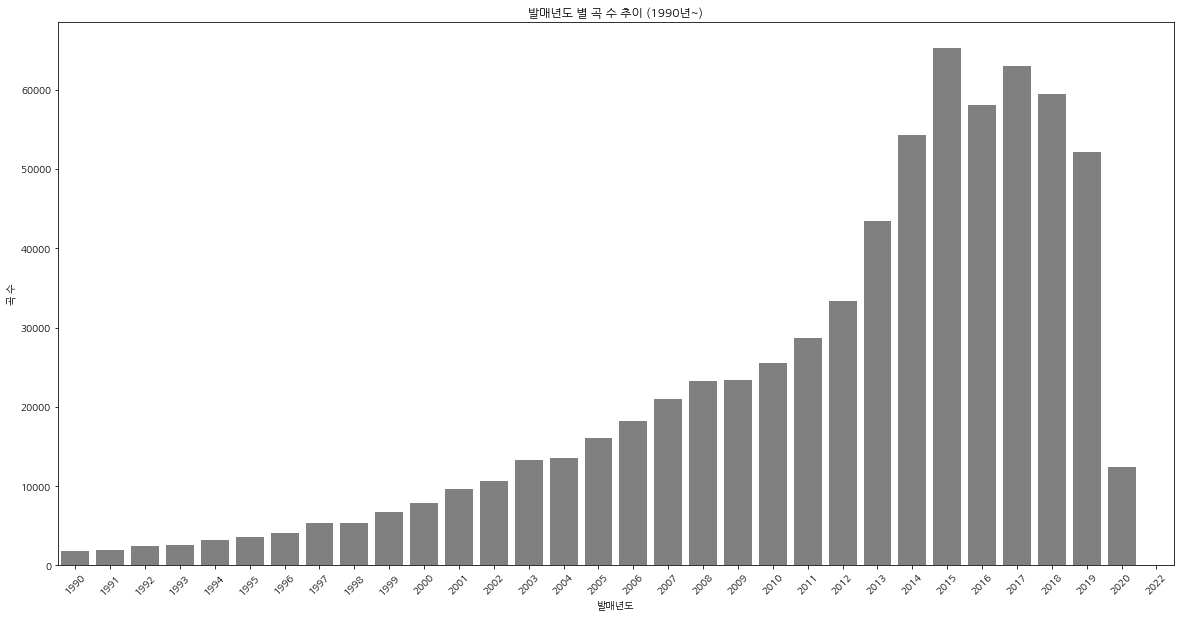

In [21]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 45)
plt.show()

- 1990년 이후로 각 곡들의 발매년도 별 곡의 비중을 확인해본 결과 **2014~2019년도에 발매된 곡의 비중**이 높았습니다.  
  (실제 전체 메타 풀에서 약 50% 정도의 비중을 보임)

<br><br><br>

## 3. 학습 데이터 : `train.json`

### 데이터 불러오기

In [22]:
train = pd.read_json('train.json', typ = 'frame', encoding='utf-8')

In [23]:
train

,tags,id,plylst_title,songs,like_cnt,updt_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000
...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000


In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115071 entries, 0 to 115070
Data columns (total 6 columns):
tags            115071 non-null object
id              115071 non-null int64
plylst_title    115071 non-null object
songs           115071 non-null object
like_cnt        115071 non-null int64
updt_date       115071 non-null object
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


- 학습 데이터에는 **총 115,071개 플레이리스트 정보가 담겨져 있으며** 포함하는 값은 아래와 같습니다.
  + `tags` : 플레이리스트에 매핑된 태그
  + `id` : 플레이리스트 아이디
  + `plylst_title` : 플레이리스트 명
  + `songs` : 플레이리스트 내 수록된 곡 아이디
  + `like_cnt` : 플레이리스트 좋아요 횟수
  + `updt_date` : 플레이리스트 업데이트 일시

In [25]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = train[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

In [26]:
plylst_song_map

,id,songs
0,61281,525514
1,61281,129701
2,61281,383374
3,61281,562083
4,61281,297861
...,...,...
5285866,100389,111365
5285867,100389,51373
5285868,100389,640239
5285869,100389,13759


In [27]:
# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = train[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

In [28]:
plylst_tag_map

,id,tags
0,61281,락
1,10532,추억
2,10532,회상
3,76951,까페
4,76951,잔잔한
...,...,...
476326,131982,퇴근길
476327,100389,노래추천
476328,100389,팝송추천
476329,100389,팝송


In [29]:
train_uniq_song_cnt = plylst_song_map.songs.nunique() # 유니크 곡 수
train_uniq_tag_cnt = plylst_tag_map.tags.nunique() # 유니크 태그 수

print('곡 수 : %s' %train_uniq_song_cnt)
print('태그 수 : %s' %train_uniq_tag_cnt)

곡 수 : 615142
태그 수 : 29160


## 곡 별 모든 정보 포함된 테이블 만들기 시작

In [51]:
plylst_tag_map['id'] = plylst_tag_map['id'].astype('int')
plylst_tag_map.info()
plylst_song_map['id'] = plylst_song_map['id'].astype('int')
plylst_song_map['songs'] = plylst_song_map['songs'].astype('int')
plylst_song_map.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476331 entries, 0 to 476330
Data columns (total 2 columns):
id      476331 non-null int32
tags    476331 non-null object
dtypes: int32(1), object(1)
memory usage: 5.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285871 entries, 0 to 5285870
Data columns (total 2 columns):
id       int32
songs    int32
dtypes: int32(2)
memory usage: 40.3 MB


In [53]:
# 각 플레이리스트에 붙은 모든 태그 정리
tmp = plylst_tag_map.groupby('id').agg(lambda x: x.tolist())
tmp = tmp.reset_index()
tmp.head()

,id,tags
0,1,"[힙합, 랩]"
1,2,"[밤, 새벽]"
2,4,"[tv별책부록, 프로듀스101, 프로듀스101시즌2]"
3,5,"[감성, 카페, 봄노래, 드라이브, 여행, 휴식, 기분전환, 사랑, 힐링, 신나는]"
4,6,"[헬스음악, 헬스장, 운동할때신나는음악, 런닝머신_뛰면서_듣기좋은, 런닝머신뛸때, ..."


In [54]:
len(plylst_tag_map), len(tmp), len(train['id'].unique())

(476331, 115071, 115071)

In [55]:
merge = pd.merge(plylst_song_map, tmp, 'left', on=['id'])
len(merge)

5285871

In [56]:
merge.head()

,id,songs,tags
0,61281,525514,[락]
1,61281,129701,[락]
2,61281,383374,[락]
3,61281,562083,[락]
4,61281,297861,[락]


In [58]:
plst_title = train[['id', 'plylst_title']]
plst_title.head()

,id,plylst_title
0,61281,여행같은 음악
1,10532,요즘 너 말야
2,76951,"편하게, 잔잔하게 들을 수 있는 곡.-"
3,147456,크리스마스 분위기에 흠뻑 취하고 싶을때
4,27616,추억의 노래 ㅋ


In [59]:
#### 플레이리스트 이름 넣기
merge2 = pd.merge(merge, plst_title, 'left', on='id')
len(merge2)

5285871

In [60]:
merge2.head()

,id,songs,tags,plylst_title
0,61281,525514,[락],여행같은 음악
1,61281,129701,[락],여행같은 음악
2,61281,383374,[락],여행같은 음악
3,61281,562083,[락],여행같은 음악
4,61281,297861,[락],여행같은 음악


In [65]:
merge2.to_csv('플스아디송아디태그플스타이틀.csv', encoding='utf-8', index=False)

### 곡으로 groupby
* 들어갈 정보: 곡 아디, 곡 이름, 가수 이름, 태그 묶음, 플레이리스트 아디 묶음, 수록된 플레이리스트 이름 묶음

In [72]:
songs = merge2.groupby('songs')[['id','tags','plylst_title']].agg(lambda x: x.tolist())
songs.head()

,id,tags,plylst_title
songs,,,
0,"[95563, 100446]","[[비오는날, 드라이브], [비오는날, 추억, 회상]]","[하루만. 이라도~~~, 듣고 보면 아하! 죽기전에 들어 본 영화음악]"
3,"[36535, 122757, 90008, 81132, 8026, 142296, 11...","[[1], [감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는],...","[1234, 어디론가로 떠나고 싶은 당신에게, 여행을 간 듯한 느낌의 POP, 분위..."
4,"[78366, 14487]","[[뉴에이지], [뉴에이지]]","[뉴에이지3, Newage Music]"
5,"[55965, 44509, 146468, 149029, 38951]","[[비오는날], [재즈], [락], [발라드], [휴식, 리메이크, 재즈, 힐링송,...","[듣기편하고 아름다운 노래들~~♬, 2010 자라섬 재즈 페스티벌(국내 아티스트),..."
6,[12244],"[[클래식, 산책, 조깅]]","[""Walking"" 클래식, 산책하며 듣는 음악]"


In [76]:
songs = songs.reset_index()
songs.columns = ['song_id', 'plst_id', 'tags', 'plst_title']
songs.head() # 여기에 없는 song_id는 플레이리스트에 한 번도 속하지 못한 곡

,song_id,plst_id,tags,plst_title
0,0,"[95563, 100446]","[[비오는날, 드라이브], [비오는날, 추억, 회상]]","[하루만. 이라도~~~, 듣고 보면 아하! 죽기전에 들어 본 영화음악]"
1,3,"[36535, 122757, 90008, 81132, 8026, 142296, 11...","[[1], [감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는],...","[1234, 어디론가로 떠나고 싶은 당신에게, 여행을 간 듯한 느낌의 POP, 분위..."
2,4,"[78366, 14487]","[[뉴에이지], [뉴에이지]]","[뉴에이지3, Newage Music]"
3,5,"[55965, 44509, 146468, 149029, 38951]","[[비오는날], [재즈], [락], [발라드], [휴식, 리메이크, 재즈, 힐링송,...","[듣기편하고 아름다운 노래들~~♬, 2010 자라섬 재즈 페스티벌(국내 아티스트),..."
4,6,[12244],"[[클래식, 산책, 조깅]]","[""Walking"" 클래식, 산책하며 듣는 음악]"


### tags 리스트 하나로만 묶기

In [89]:
pro = songs['tags'].loc[0]
pro

[['비오는날', '드라이브'], ['비오는날', '추억', '회상']]

In [91]:
lst = []
for i in pro:
    for j in range(len(i)):
        lst.append(i[j])

In [92]:
lst

['비오는날', '드라이브', '비오는날', '추억', '회상']

In [100]:
new_tags2 = []
for onerow in songs['tags']:
    new_tags = []
    if len(onerow) > 2:
        for onelst in onerow:
            for onetag in range(len(onelst)):
                new_tags.append(onelst[onetag])
    else:
        for alist in onerow:
            new_tags.extend(alist)
    
    new_tags2.append(new_tags)

In [101]:
new_tags2

[['비오는날', '드라이브', '비오는날', '추억', '회상'],
 ['1',
  '감성',
  '듣기좋은',
  '드라이브',
  'Pop',
  '여행',
  '기분전환',
  '팝',
  '신나는',
  '클럽',
  '매장음악',
  '드라이브',
  'EDM모음',
  '페스티벌',
  '기분전환',
  '스트레스',
  '신나는',
  'dance',
  'house',
  '여름',
  'tropical',
  '일렉',
  '편집숍',
  '힙스터',
  '기분전환',
  '운동',
  '축제',
  '클럽',
  '운동',
  'Festival',
  'EDM',
  '불금',
  '페스티벌',
  '파티',
  '즐거운',
  '신나는'],
 ['뉴에이지', '뉴에이지'],
 ['비오는날',
  '재즈',
  '락',
  '발라드',
  '휴식',
  '리메이크',
  '재즈',
  '힐링송',
  '힐링',
  '기분전환',
  '기분_전환',
  '음악'],
 ['클래식', '산책', '조깅'],
 ['클래식', '코로나'],
 ['위로', '발라드', '감성', '발라드'],
 ['재즈힙합',
  '인디',
  '감성',
  '유럽여행',
  '유럽',
  '여행',
  'Chill',
  '감성',
  '밤',
  '편안한',
  'JAYJE',
  '아날로그',
  'Lofi',
  '로파이',
  '공부할때',
  '배경음악',
  'Chill',
  '멜로우비트',
  '재즈',
  '멜로우힙합',
  'Lofihiphop',
  '재즈힙합',
  '빈티지',
  '빈티지감성',
  '로파이',
  'Lofi',
  '새벽감성',
  'Lofihiphop',
  '로파이힙합',
  '로파이',
  'Summer',
  '여름',
  'Pop',
  '힙합',
  '마이너감성',
  '재즈',
  'Lofi',
  '재즈힙합',
  '로파이',
  '휴식',
  '알앤비',
  '그루브',
  '재지한',
  '재즈힙합',
  

In [99]:
new_tags # 모든 태그 모음

['비오는날',
 '드라이브',
 '비오는날',
 '추억',
 '회상',
 '1',
 '감성',
 '듣기좋은',
 '드라이브',
 'Pop',
 '여행',
 '기분전환',
 '팝',
 '신나는',
 '클럽',
 '매장음악',
 '드라이브',
 'EDM모음',
 '페스티벌',
 '기분전환',
 '스트레스',
 '신나는',
 'dance',
 'house',
 '여름',
 'tropical',
 '일렉',
 '편집숍',
 '힙스터',
 '기분전환',
 '운동',
 '축제',
 '클럽',
 '운동',
 'Festival',
 'EDM',
 '불금',
 '페스티벌',
 '파티',
 '즐거운',
 '신나는',
 '뉴에이지',
 '뉴에이지',
 '비오는날',
 '재즈',
 '락',
 '발라드',
 '휴식',
 '리메이크',
 '재즈',
 '힐링송',
 '힐링',
 '기분전환',
 '기분_전환',
 '음악',
 '클래식',
 '산책',
 '조깅',
 '클래식',
 '코로나',
 '위로',
 '발라드',
 '감성',
 '발라드',
 '재즈힙합',
 '인디',
 '감성',
 '유럽여행',
 '유럽',
 '여행',
 'Chill',
 '감성',
 '밤',
 '편안한',
 'JAYJE',
 '아날로그',
 'Lofi',
 '로파이',
 '공부할때',
 '배경음악',
 'Chill',
 '멜로우비트',
 '재즈',
 '멜로우힙합',
 'Lofihiphop',
 '재즈힙합',
 '빈티지',
 '빈티지감성',
 '로파이',
 'Lofi',
 '새벽감성',
 'Lofihiphop',
 '로파이힙합',
 '로파이',
 'Summer',
 '여름',
 'Pop',
 '힙합',
 '마이너감성',
 '재즈',
 'Lofi',
 '재즈힙합',
 '로파이',
 '휴식',
 '알앤비',
 '그루브',
 '재지한',
 '재즈힙합',
 '팝',
 '편안한',
 '깊은밤',
 '신용산',
 '몰티드',
 '카페투어',
 '분위기있는',
 '취향저격DJ',
 'bgm',
 '카페',
 '밤',
 '새벽',

In [102]:
songs2 = songs.copy()
del songs2['tags']
songs2['tags'] = new_tags2
songs2.head()

,song_id,plst_id,plst_title,tags
0,0,"[95563, 100446]","[하루만. 이라도~~~, 듣고 보면 아하! 죽기전에 들어 본 영화음악]","[비오는날, 드라이브, 비오는날, 추억, 회상]"
1,3,"[36535, 122757, 90008, 81132, 8026, 142296, 11...","[1234, 어디론가로 떠나고 싶은 당신에게, 여행을 간 듯한 느낌의 POP, 분위...","[1, 감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는, 클럽,..."
2,4,"[78366, 14487]","[뉴에이지3, Newage Music]","[뉴에이지, 뉴에이지]"
3,5,"[55965, 44509, 146468, 149029, 38951]","[듣기편하고 아름다운 노래들~~♬, 2010 자라섬 재즈 페스티벌(국내 아티스트),...","[비오는날, 재즈, 락, 발라드, 휴식, 리메이크, 재즈, 힐링송, 힐링, 기분전환..."
4,6,[12244],"[""Walking"" 클래식, 산책하며 듣는 음악]","[클래식, 산책, 조깅]"


In [103]:
songs2.to_csv('song자체메타.csv', encoding='utf-8', index=False)

### 곡 이름, 가수 이름, 발매일(추천 시기 고려 위해) 붙이기

In [114]:
song_meta2 = song_meta[['id', 'song_name', 'artist_name_basket', 'issue_date']]
song_meta2.head()

,id,song_name,artist_name_basket,issue_date
0,0,Feelings,[Various Artists],20140512
1,1,"Bach : Partita No. 4 In D Major, BWV 828 - II....",[Murray Perahia],20080421
2,2,Solsbury Hill (Remastered 2002),[Peter Gabriel],20180518
3,3,Feeling Right (Everything Is Nice) (Feat. Popc...,[Matoma],20151016
4,4,그남자 그여자,[Jude Law],20110824


In [115]:
song_meta2['id'] = song_meta2['id'].astype('int')
song_meta2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707989 entries, 0 to 707988
Data columns (total 4 columns):
id                    707989 non-null int32
song_name             707989 non-null object
artist_name_basket    707989 non-null object
issue_date            707989 non-null int64
dtypes: int32(1), int64(1), object(2)
memory usage: 18.9+ MB


In [116]:
songs3 = pd.merge(songs2, song_meta2, 'left', left_on='song_id', right_on='id')
songs3.head()

,song_id,plst_id,plst_title,tags,id,song_name,artist_name_basket,issue_date
0,0,"[95563, 100446]","[하루만. 이라도~~~, 듣고 보면 아하! 죽기전에 들어 본 영화음악]","[비오는날, 드라이브, 비오는날, 추억, 회상]",0,Feelings,[Various Artists],20140512
1,3,"[36535, 122757, 90008, 81132, 8026, 142296, 11...","[1234, 어디론가로 떠나고 싶은 당신에게, 여행을 간 듯한 느낌의 POP, 분위...","[1, 감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는, 클럽,...",3,Feeling Right (Everything Is Nice) (Feat. Popc...,[Matoma],20151016
2,4,"[78366, 14487]","[뉴에이지3, Newage Music]","[뉴에이지, 뉴에이지]",4,그남자 그여자,[Jude Law],20110824
3,5,"[55965, 44509, 146468, 149029, 38951]","[듣기편하고 아름다운 노래들~~♬, 2010 자라섬 재즈 페스티벌(국내 아티스트),...","[비오는날, 재즈, 락, 발라드, 휴식, 리메이크, 재즈, 힐링송, 힐링, 기분전환...",5,Para Los Enamorados,"[Bye, Lupita]",20100602
4,6,[12244],"[""Walking"" 클래식, 산책하며 듣는 음악]","[클래식, 산책, 조깅]",6,Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",20170208


In [117]:
del songs3['id']
songs3.head()

,song_id,plst_id,plst_title,tags,song_name,artist_name_basket,issue_date
0,0,"[95563, 100446]","[하루만. 이라도~~~, 듣고 보면 아하! 죽기전에 들어 본 영화음악]","[비오는날, 드라이브, 비오는날, 추억, 회상]",Feelings,[Various Artists],20140512
1,3,"[36535, 122757, 90008, 81132, 8026, 142296, 11...","[1234, 어디론가로 떠나고 싶은 당신에게, 여행을 간 듯한 느낌의 POP, 분위...","[1, 감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는, 클럽,...",Feeling Right (Everything Is Nice) (Feat. Popc...,[Matoma],20151016
2,4,"[78366, 14487]","[뉴에이지3, Newage Music]","[뉴에이지, 뉴에이지]",그남자 그여자,[Jude Law],20110824
3,5,"[55965, 44509, 146468, 149029, 38951]","[듣기편하고 아름다운 노래들~~♬, 2010 자라섬 재즈 페스티벌(국내 아티스트),...","[비오는날, 재즈, 락, 발라드, 휴식, 리메이크, 재즈, 힐링송, 힐링, 기분전환...",Para Los Enamorados,"[Bye, Lupita]",20100602
4,6,[12244],"[""Walking"" 클래식, 산책하며 듣는 음악]","[클래식, 산책, 조깅]",Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",20170208


In [119]:
songs3.to_csv('곡별테이블.csv', encoding='utf-8', index=False) # 리스트 형식 데이터는 깨짐

In [122]:
import pickle
# save
with open('곡별테이블.pickle', 'wb') as f:
    pickle.dump(songs3, f, pickle.HIGHEST_PROTOCOL)

# load
with open('곡별테이블.pickle', 'rb') as f:
    data = pickle.load(f)
data.head()

,song_id,plst_id,plst_title,tags,song_name,artist_name_basket,issue_date
0,0,"[95563, 100446]","[하루만. 이라도~~~, 듣고 보면 아하! 죽기전에 들어 본 영화음악]","[비오는날, 드라이브, 비오는날, 추억, 회상]",Feelings,[Various Artists],20140512
1,3,"[36535, 122757, 90008, 81132, 8026, 142296, 11...","[1234, 어디론가로 떠나고 싶은 당신에게, 여행을 간 듯한 느낌의 POP, 분위...","[1, 감성, 듣기좋은, 드라이브, Pop, 여행, 기분전환, 팝, 신나는, 클럽,...",Feeling Right (Everything Is Nice) (Feat. Popc...,[Matoma],20151016
2,4,"[78366, 14487]","[뉴에이지3, Newage Music]","[뉴에이지, 뉴에이지]",그남자 그여자,[Jude Law],20110824
3,5,"[55965, 44509, 146468, 149029, 38951]","[듣기편하고 아름다운 노래들~~♬, 2010 자라섬 재즈 페스티벌(국내 아티스트),...","[비오는날, 재즈, 락, 발라드, 휴식, 리메이크, 재즈, 힐링송, 힐링, 기분전환...",Para Los Enamorados,"[Bye, Lupita]",20100602
4,6,[12244],"[""Walking"" 클래식, 산책하며 듣는 음악]","[클래식, 산책, 조깅]",Sibelius : Valse Triste Op.44 (시벨리우스 : 슬픈 왈츠 작...,"[Herbert Blomstedt, San Francisco Symphony]",20170208


In [ ]:
songs3[songs3['song_name']=='밤편지'].iloc[0]['plst_title']

* 플레이리스트 제목에 감성 관련 단어가 들어가있으면 분위기가 비슷한 노래 추천
* 플레이리스트 제목에 가수 이름이 들어가 있으면 그 가수 위주로 추천해줘야 함.
* 우리나라 노래 모음이랑 외국 노래 모음이랑도 신경써서 구분해야 할 듯

<br>

<br>